In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## define param_dict

In [4]:
gdr = 0.04
param_dict = {
    'init_HSFA1': 1,
    'init_C_HSFA1_HSPR': 50,
    'init_HSPR': 2,
    'init_MMP': 0,
    'init_FMP': 5000,
    'init_C_HSPR_MMP': 50,
    'init_HSFB': 1,
    'Time': 0.0,
    ## Maximum expression level in Hill equation
    'a1': 10,
    'a2': 100,
    'a5': 10,
    'a6': 0.2, # refolding rate from MMP-HSPR
    'a7': 300, #folded protein production rate
    #'a8': 50.0,
    ## Ka in Hill equation
    'h1': 1,
    'h2': 1,
    #'h3': int(opt.hBA),
    #'h4': int(opt.hBH),
    'h5': 1,
    #'h6': int(opt.hBB),
    ## association rates
    'c1': 10, # binding rate between A1 and HSPR
    'c3': 0.5, # binding rate between MMP and HSPR
    'c2':0.5,
    'c4':0.5,
    ## decay rates
    'd1': 0.1, # dissociation rate of A1-HSPR
    'd1_HS': 1,
    'd3': 0.01, # dissociation rate of MMP-HSPR
    'd4_heat': 0.05,
    'd4_norm': 0.01,
    'd4':0.01,
    'Decay1': gdr,
    'Decay2': gdr, # decay of free HSPR
    'Decay4': gdr,
    'Decay6': gdr,
    'Decay7': gdr, # decay path 2 of A1-HSPR
    'Decay8': gdr, # decay of MMP-HSPR. Make sense for it to be higher than normal complexes/proteins
    'Decay5': 0.1,
    ####
    'leakage_A1': 0.001,
    'leakage_B': 0.001,
    'leakage_HSPR': 0.001,
    'hillcoeff': 2,

}

In [1]:
param_dict = {
    ## initial concentrations
    'init_HSFA1': 1,
    'init_C_HSFA1_HSPR': 50,
    'init_HSPR': 50,
    'init_MMP': 0,
    'init_FMP': 5000,
    'init_C_HSPR_MMP': 50,
    'init_HSFB': 1,
    'Time': 0.0,
    ## Maximum expression level in Hill equation
    'a1': 50,
    'a2': 500,
    'a5': 25,
    'a6': 0.2, # refolding rate from MMP-HSPR
    'a7': 1000, #folded protein production rate
    #'a8': 50.0,
    ## Ka in Hill equation
    'h1': 10,
    'h2': 10,
    'h5': 10,
    ## association rates
    'c1': 10, # binding rate between A1 and HSPR
    'c3': 5, # binding rate between MMP and HSPR
    ## decay rates
    'd1': 0.1, # decay path 1 of A1-HSPR
    'd3': 0.01, # dissociation rate of MMP-HSPR
    'd4': 0.01,
    'Decay1': 0.04,
    'Decay2': 0.04, # decay of free HSPR
    'Decay4': 0.04,
    'Decay6': 0.04,
    'Decay7': 0.04, # decay path 2 of A1-HSPR
    'Decay8': 0.04, # decay of MMP-HSPR. Make sense for it to be higher than normal complexes/proteins
    'Decay5': 0.1,
    ####
    'leakage_A1': 0.001,
    'leakage_B': 0.001,
    'leakage_HSPR': 0.001,
    'hillcoeff': 3,
}

## defining and solving ODE system

In [5]:
def unpack_param_dict(param_dict):
    a1 = float(param_dict['a1'])
    a2 = float(param_dict['a2'])
    a5 = float(param_dict['a5'])
    a6 = float(param_dict['a6'])
    a7 = float(param_dict['a7'])
    h1 = float(param_dict['h1'])
    h2 = float(param_dict['h2'])
    h5 = float(param_dict['h5'])
    c1 = float(param_dict['c1'])
    c3 = float(param_dict['c3'])
    d1 = float(param_dict['d1'])
    d3 = float(param_dict['d3'])
    d4 = float(param_dict['d4'])
    Decay1 = float(param_dict['Decay1'])
    Decay2 = float(param_dict['Decay2'])
    Decay4 = float(param_dict['Decay4'])
    Decay6 = float(param_dict['Decay6'])
    Decay7 = float(param_dict['Decay7'])
    Decay8 = float(param_dict['Decay8'])
    Decay5 = float(param_dict['Decay5'])
    n = int(param_dict['hillcoeff'])
    try: 
        leakage_A1 = float(param_dict['leakage_A1'])
        leakage_B = float(param_dict['leakage_B'])
        leakage_HSPR = float(param_dict['leakage_HSPR'])
    except KeyError:
        leakage_A1, leakage_B, leakage_HSPR = float(param_dict['leakage']), float(param_dict['leakage']), float(param_dict['leakage'])
    
    return a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n


In [6]:
# Define the system of ODEs
def ode_system_core(t, y, params):
    # Unpack the dependent variables
    HSFA1, HSPR, C_HSFA1_HSPR, MMP, FMP, C_HSPR_MMP, HSFB = y

    # Unpack the parameters
    a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n = params
    
    # Define the system of ODEs
    dA1_dt = leakage_A1 + a1*HSFA1**n/(h1**n+HSFA1**n+HSFB**n) - Decay1*HSFA1 - c1*HSFA1*HSPR + d1*C_HSFA1_HSPR
    dHSPR_dt = leakage_HSPR+a2*HSFA1**n/(h2**n+HSFA1**n+HSFB**n) - Decay2*HSPR - c1*HSFA1*HSPR - c3*HSPR*MMP + d1*C_HSFA1_HSPR + d3*C_HSPR_MMP + a6*C_HSPR_MMP
    dC_A1_HSPR_dt = c1*HSFA1*HSPR - d1*C_HSFA1_HSPR - Decay7*C_HSFA1_HSPR
    dMMP_dt = d4*FMP - Decay5*MMP - c3*HSPR*MMP + d3*C_HSPR_MMP
    dFMP_dt = a7 - Decay6*FMP - d4*FMP + a6*C_HSPR_MMP
    dC_HSPR_MMP_dt = c3*HSPR*MMP - d3*C_HSPR_MMP - a6*C_HSPR_MMP - Decay8*C_HSPR_MMP
    dB_dt = leakage_B+a5*HSFA1**n/(h5**n+HSFA1**n+HSFB**n) - Decay4*HSFB

    return [dA1_dt, dHSPR_dt, dC_A1_HSPR_dt, dMMP_dt, dFMP_dt, dC_HSPR_MMP_dt, dB_dt]



In [7]:
# Define initial conditions
y0 = np.array([int(param_dict["init_HSFA1"]),
                      int(param_dict["init_HSPR"]),
                      int(param_dict["init_C_HSFA1_HSPR"]),
                      int(param_dict["init_MMP"]),
                      int(param_dict["init_FMP"]),
                      int(param_dict["init_C_HSPR_MMP"]),
                      int(param_dict["init_HSFB"])])

# Define time span
start_time = 0
end_time, num_points = 1000, 10000
t_span = (start_time, end_time)

# Define parameters
a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n = unpack_param_dict(param_dict)
params = (a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n)
# Solve the ODE system
solution = solve_ivp(ode_system_core, t_span, y0, args=(params,), t_eval=np.linspace(start_time, end_time, num_points))


## plotting ODE result

In [8]:
# Extract results
t = solution.t
HSFA1, HSPR, C_HSFA1_HSPR, MMP, FMP, C_HSPR_MMP, HSFB = solution.y

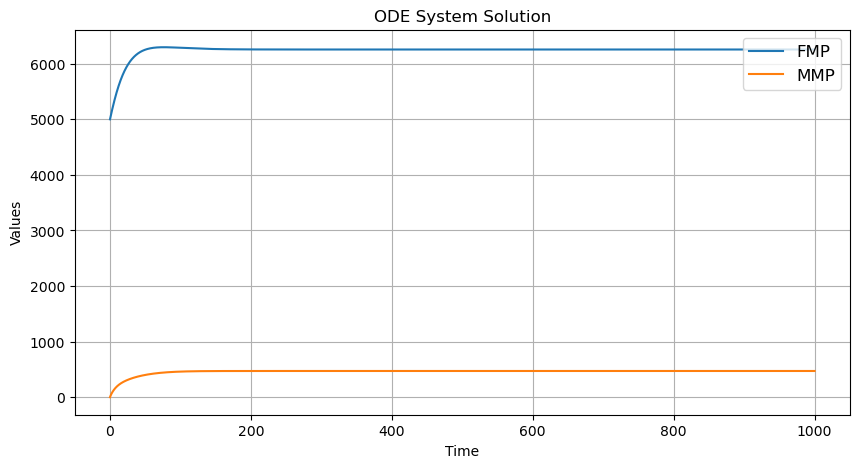

In [13]:
# Plotting results
plt.figure(figsize = (10,5))
plt.plot(t, FMP, label = 'FMP')
plt.plot(t, MMP, label = 'MMP')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('ODE System Solution')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True)
plt.show()    


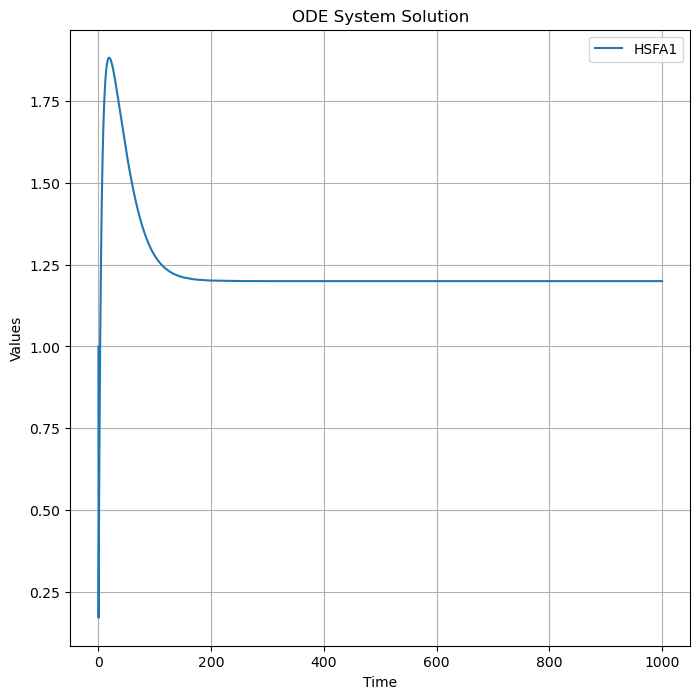

In [14]:
plt.figure(figsize = (8,8))
plt.plot(t, HSFA1, label = 'HSFA1')
#plt.plot(t, HSPR, label = 'HSPR')
#plt.plot(t, HSFB, label = 'HSFB')
#plt.plot(t, C_HSFA1_HSPR, label = 'C_HSFA1_HSPR')
#plt.plot(t, C_HSPR_MMP, label = 'C_HSPR_MMP')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('ODE System Solution')
plt.legend()
plt.grid(True)
plt.show()    

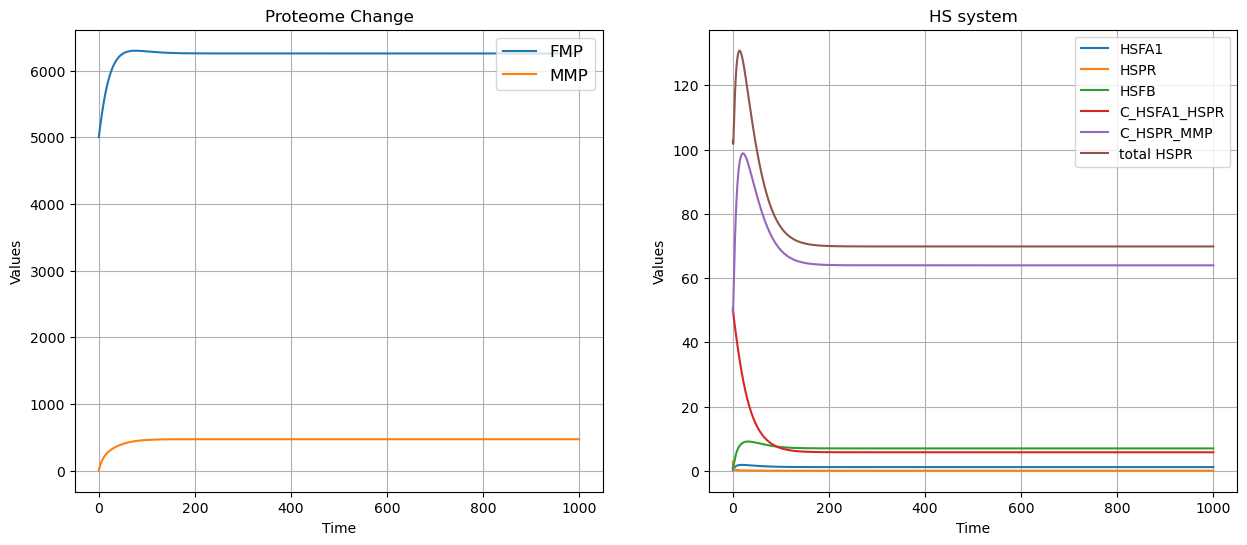

In [19]:

fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].plot(t, FMP, label = 'FMP')
ax[0].plot(t, MMP, label = 'MMP')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Values')
ax[0].set_title('Proteome Change')
ax[0].legend(loc='upper right', fontsize='large')
ax[0].grid(True)

ax[1].plot(t, HSFA1, label = 'HSFA1')
ax[1].plot(t, HSPR, label = 'HSPR')
ax[1].plot(t, HSFB, label = 'HSFB')
ax[1].plot(t, C_HSFA1_HSPR, label = 'C_HSFA1_HSPR')
ax[1].plot(t, C_HSPR_MMP, label = 'C_HSPR_MMP')
ax[1].plot(t, HSPR+C_HSFA1_HSPR+C_HSPR_MMP, label = 'total HSPR')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Values')
ax[1].set_title('HS system')
ax[1].legend()
ax[1].grid(True)
plt.show()   

## param explore

In [41]:
def plot_sol(solution, data_name):
    t = solution.t
    HSFA1, HSPR, C_HSFA1_HSPR, MMP, FMP, C_HSPR_MMP, HSFB = solution.y
    name_list = ['HSFA1', 'HSPR', 'C_HSFA1_HSPR', 'MMP', 'FMP', 'C_HSPR_MMP', 'HSFB']
    ss_string = ''
    for var_name, var in zip(name_list , solution.y):
        ss_string += f'{var_name} = {"{:.2f}".format(var[-1])}, '
    fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(t, FMP, label = 'FMP')
    ax[0].plot(t, MMP, label = 'MMP')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Values')
    ax[0].set_title('Proteome Change')
    ax[0].legend(loc='upper right', fontsize='large')
    ax[0].grid(True)

    ax[1].plot(t, HSFA1, label = 'HSFA1')
    ax[1].plot(t, HSPR, label = 'HSPR')
    ax[1].plot(t, HSFB, label = 'HSFB')
    ax[1].plot(t, C_HSFA1_HSPR, label = 'C_HSFA1_HSPR')
    ax[1].plot(t, C_HSPR_MMP, label = 'C_HSPR_MMP')
    ax[1].plot(t, HSPR+C_HSFA1_HSPR+C_HSPR_MMP, label = 'total HSPR')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Values')
    ax[1].set_title('HS system')
    ax[1].legend()
    ax[1].grid(True)
    fig.suptitle(f'{data_name}\n{ss_string}', fontsize=14, y = 1)
    plt.show()   

In [32]:
print(HSFA1)

[1.         0.25151989 0.17043184 ... 1.19988148 1.19987192 1.19988199]


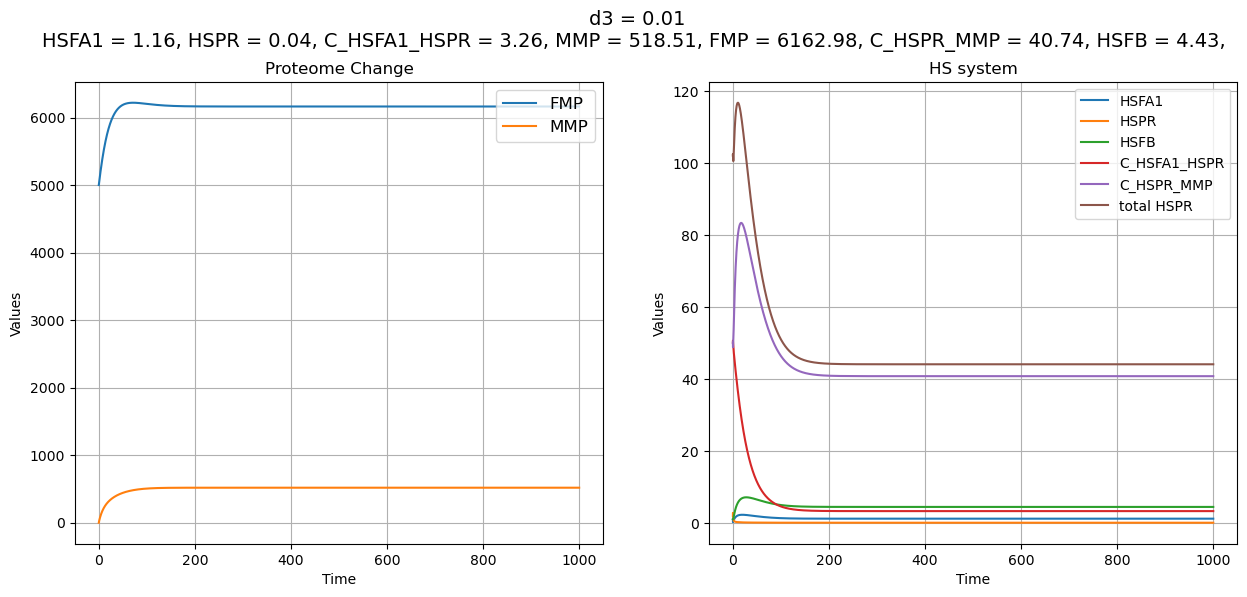

In [42]:
#unpack param
a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n = unpack_param_dict(param_dict)
#change param
n=3
h1 = 1
h2 = 1
h5 = 1
params = (a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n)
# Solve the ODE system
solution = solve_ivp(ode_system_core, t_span, y0, args=(params,), t_eval=np.linspace(start_time, end_time, num_points))
plot_sol(solution, f'd3 = {d3}')

### d3

In [23]:
print(param_dict)

{'init_HSFA1': 1, 'init_C_HSFA1_HSPR': 50, 'init_HSPR': 2, 'init_MMP': 0, 'init_FMP': 5000, 'init_C_HSPR_MMP': 50, 'init_HSFB': 1, 'Time': 0.0, 'a1': 10, 'a2': 100, 'a5': 10, 'a6': 0.2, 'a7': 300, 'h1': 1, 'h2': 1, 'h5': 1, 'c1': 10, 'c3': 0.5, 'c2': 0.5, 'c4': 0.5, 'd1': 0.1, 'd1_HS': 1, 'd3': 0.01, 'd4_heat': 0.05, 'd4_norm': 0.01, 'd4': 0.01, 'Decay1': 0.04, 'Decay2': 0.04, 'Decay4': 0.04, 'Decay6': 0.04, 'Decay7': 0.04, 'Decay8': 0.04, 'Decay5': 0.1, 'leakage_A1': 0.001, 'leakage_B': 0.001, 'leakage_HSPR': 0.001, 'hillcoeff': 2}


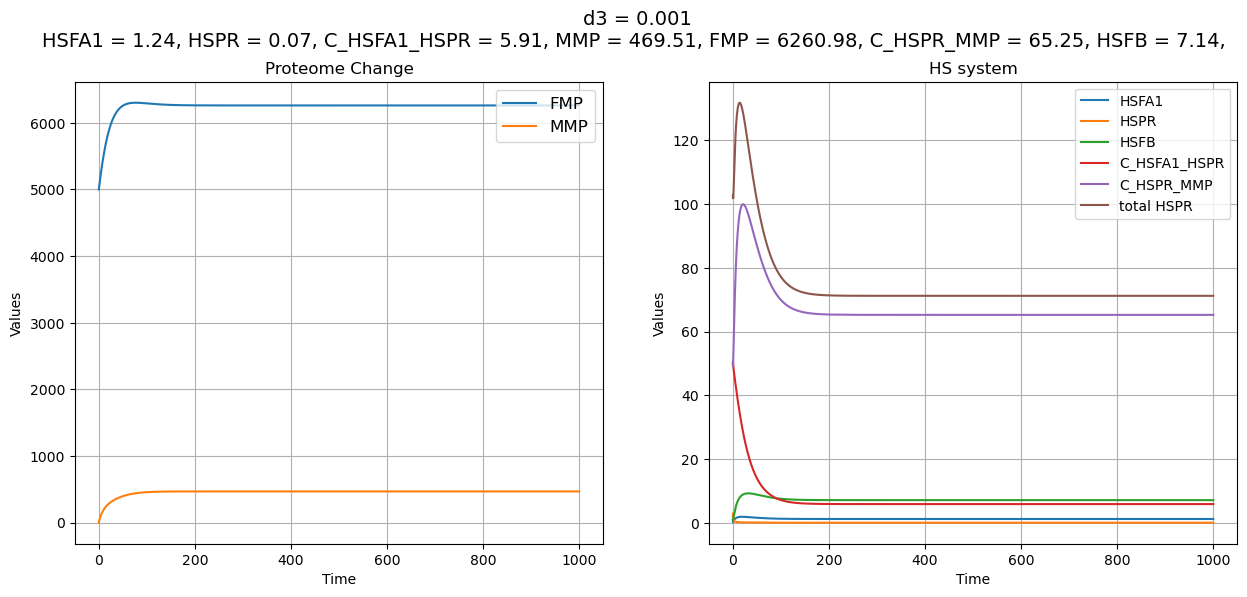

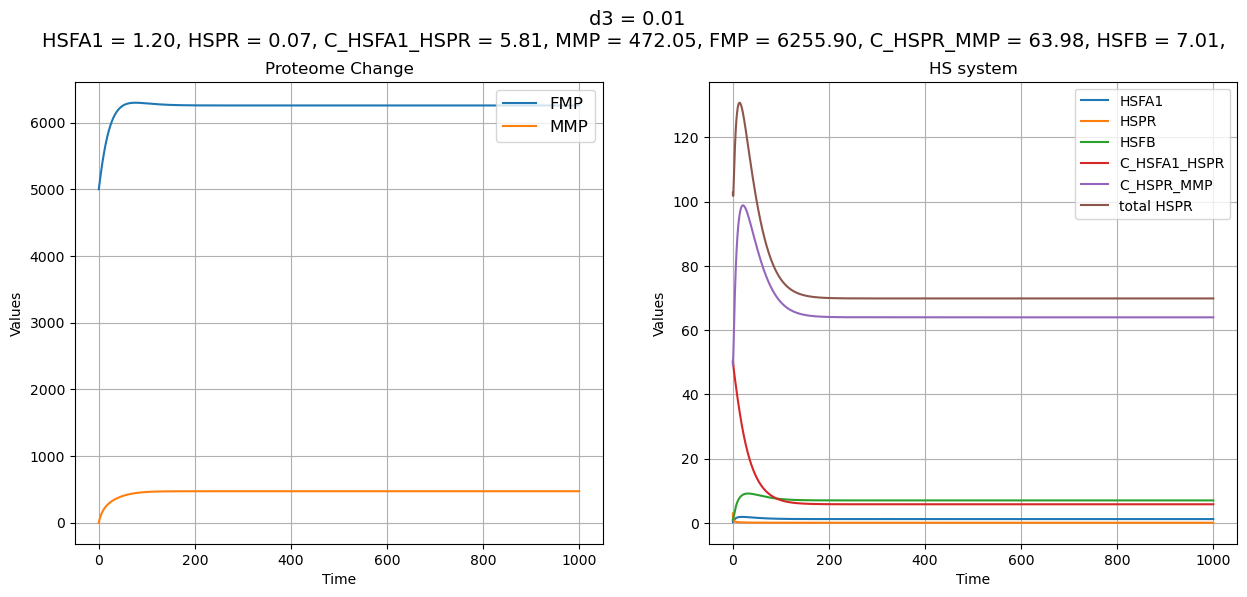

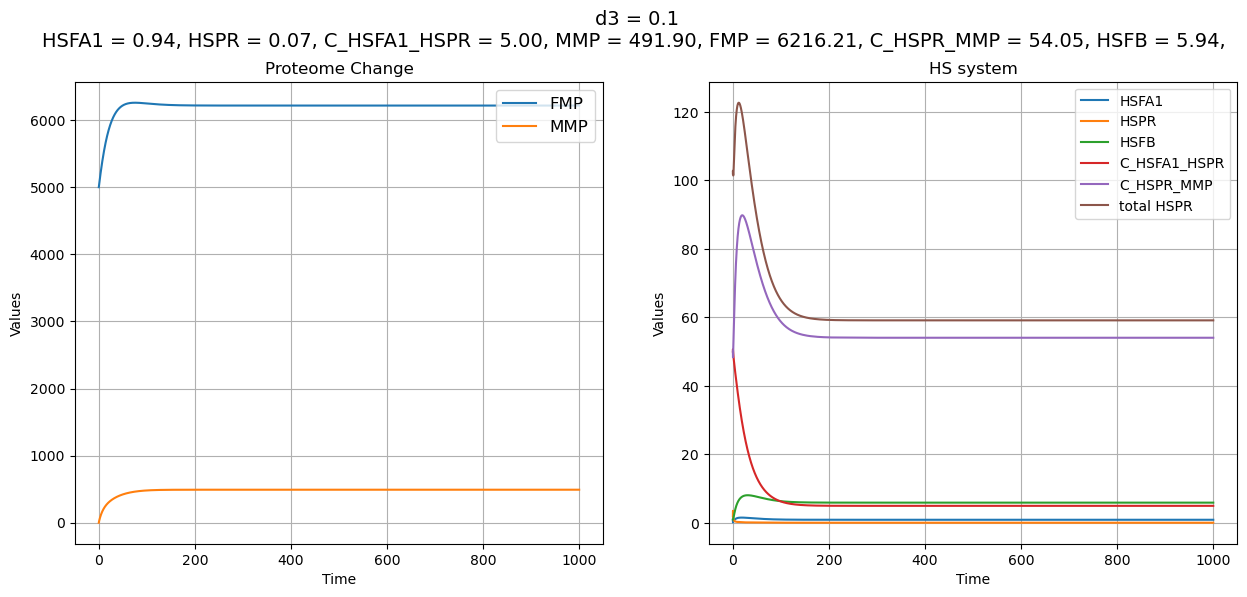

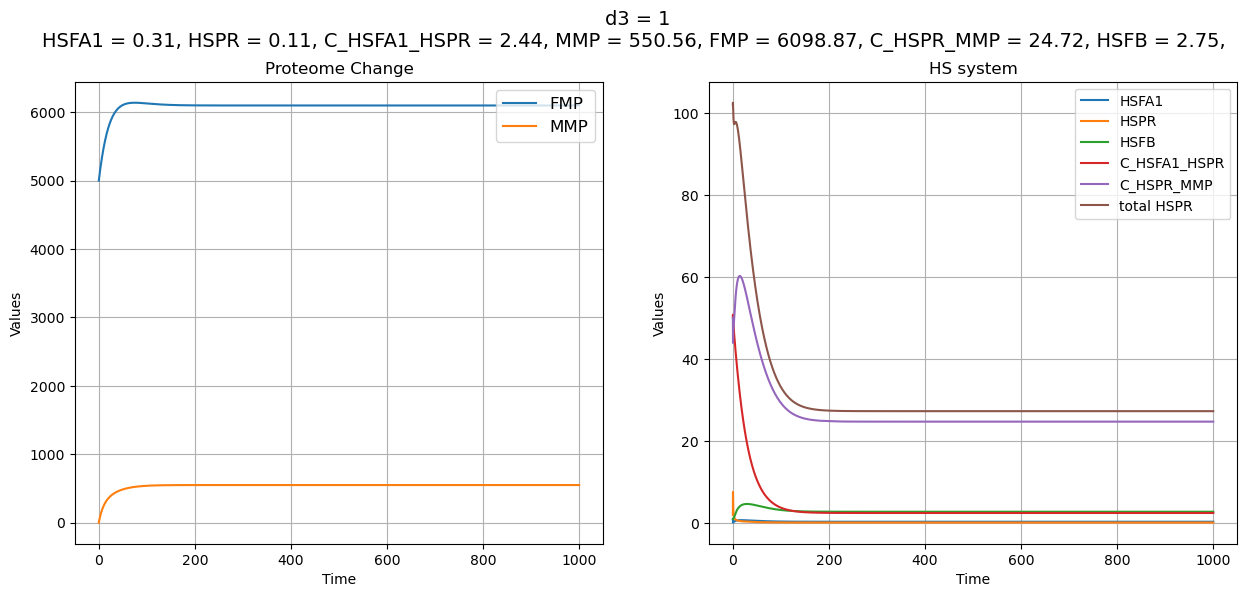

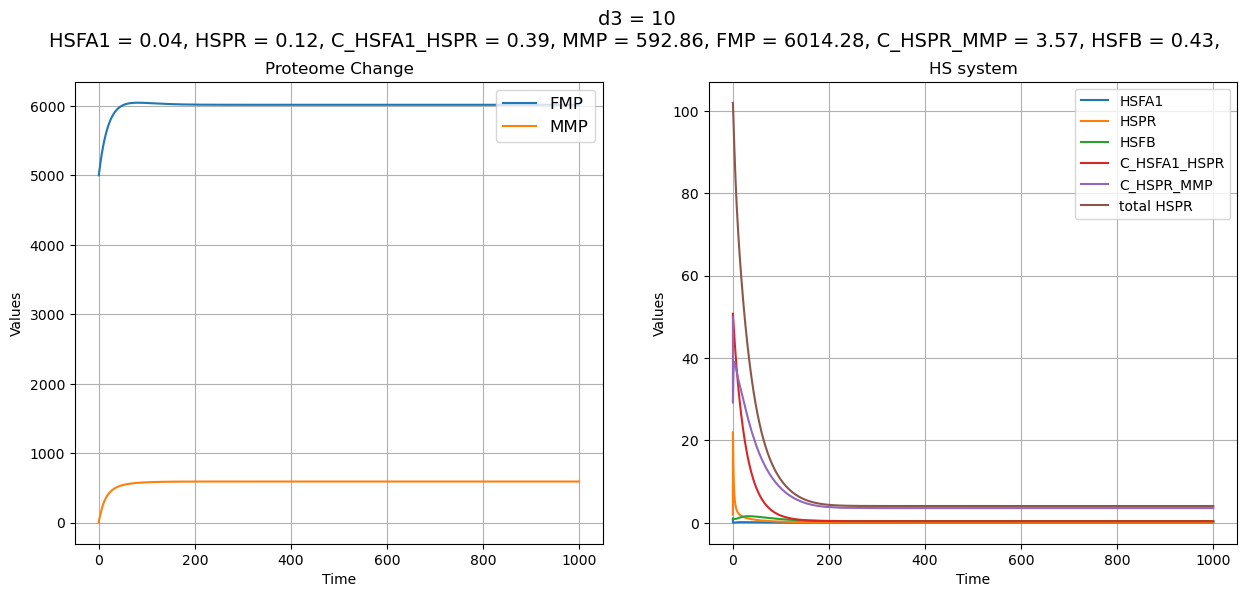

In [44]:
d3_list = [0.001, 0.01, 0.1, 1, 10]
for d3_val in d3_list:
    #unpack param
    a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n = unpack_param_dict(param_dict)
    #change param
    d3 = d3_val
    params = (a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n)
    # Solve the ODE system
    solution = solve_ivp(ode_system_core, t_span, y0, args=(params,), t_eval=np.linspace(start_time, end_time, num_points))
    plot_sol(solution, f'd3 = {d3_val}')

### d1

In [46]:
print(param_dict)

{'init_HSFA1': 1, 'init_C_HSFA1_HSPR': 50, 'init_HSPR': 2, 'init_MMP': 0, 'init_FMP': 5000, 'init_C_HSPR_MMP': 50, 'init_HSFB': 1, 'Time': 0.0, 'a1': 10, 'a2': 100, 'a5': 10, 'a6': 0.2, 'a7': 300, 'h1': 1, 'h2': 1, 'h5': 1, 'c1': 10, 'c3': 0.5, 'c2': 0.5, 'c4': 0.5, 'd1': 0.1, 'd1_HS': 1, 'd3': 0.01, 'd4_heat': 0.05, 'd4_norm': 0.01, 'd4': 0.01, 'Decay1': 0.04, 'Decay2': 0.04, 'Decay4': 0.04, 'Decay6': 0.04, 'Decay7': 0.04, 'Decay8': 0.04, 'Decay5': 0.1, 'leakage_A1': 0.001, 'leakage_B': 0.001, 'leakage_HSPR': 0.001, 'hillcoeff': 2}


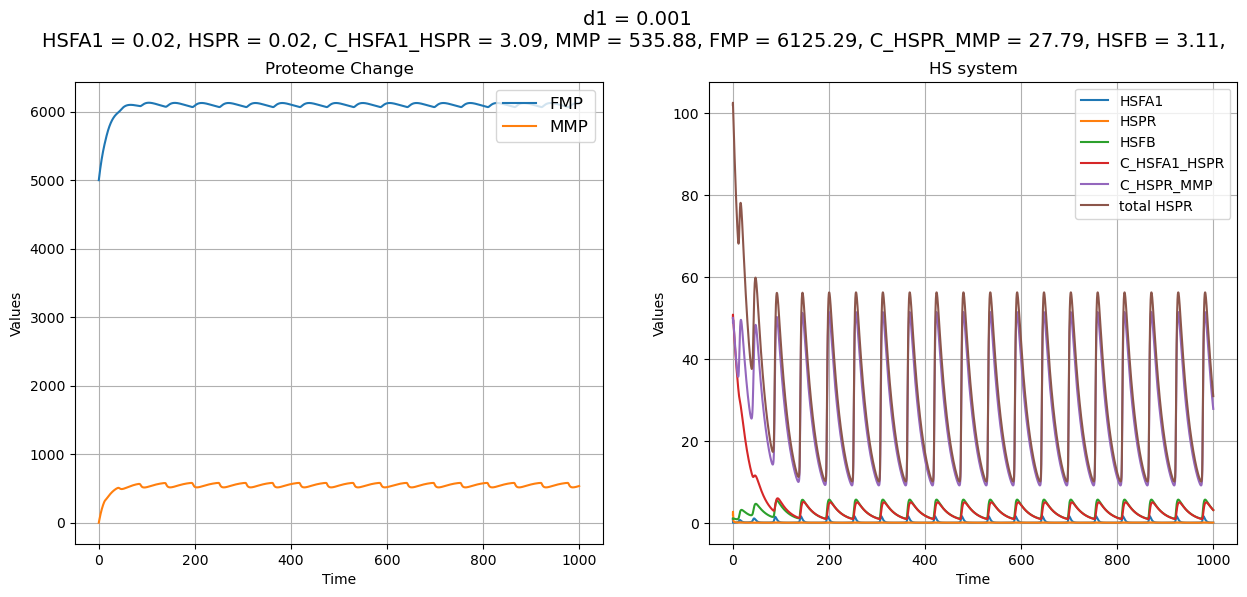

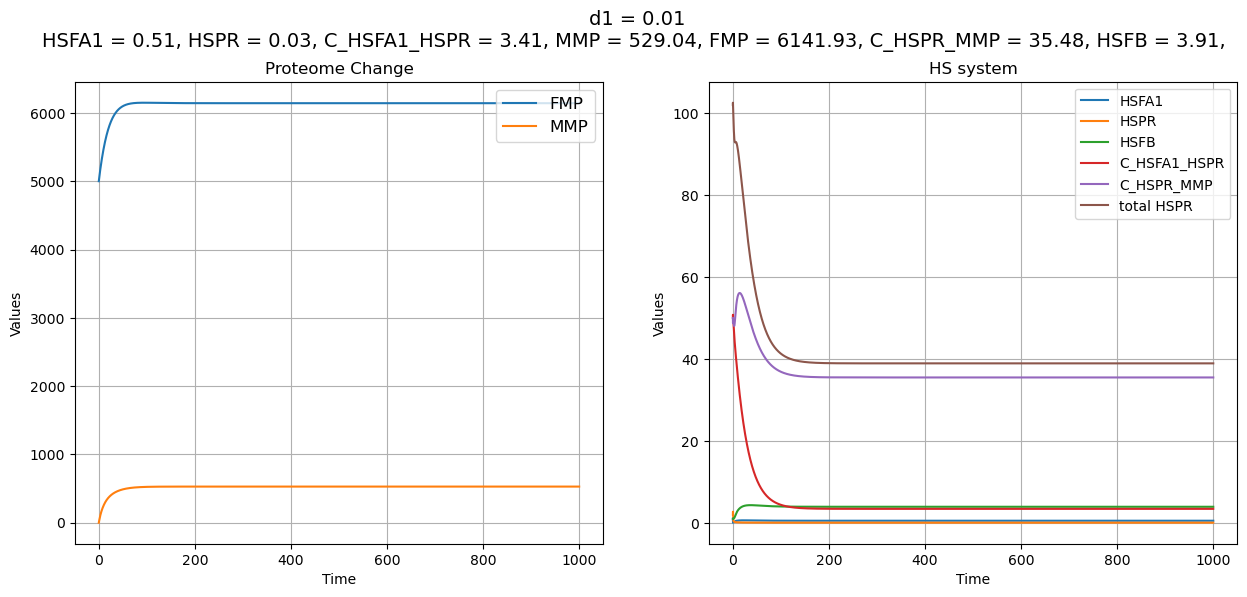

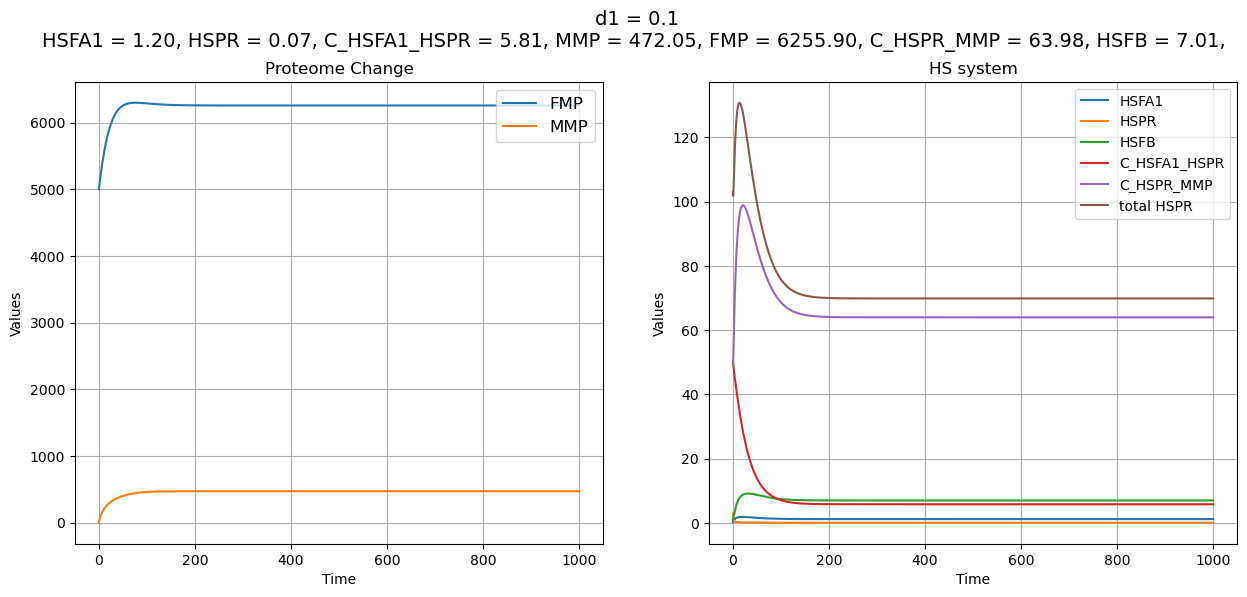

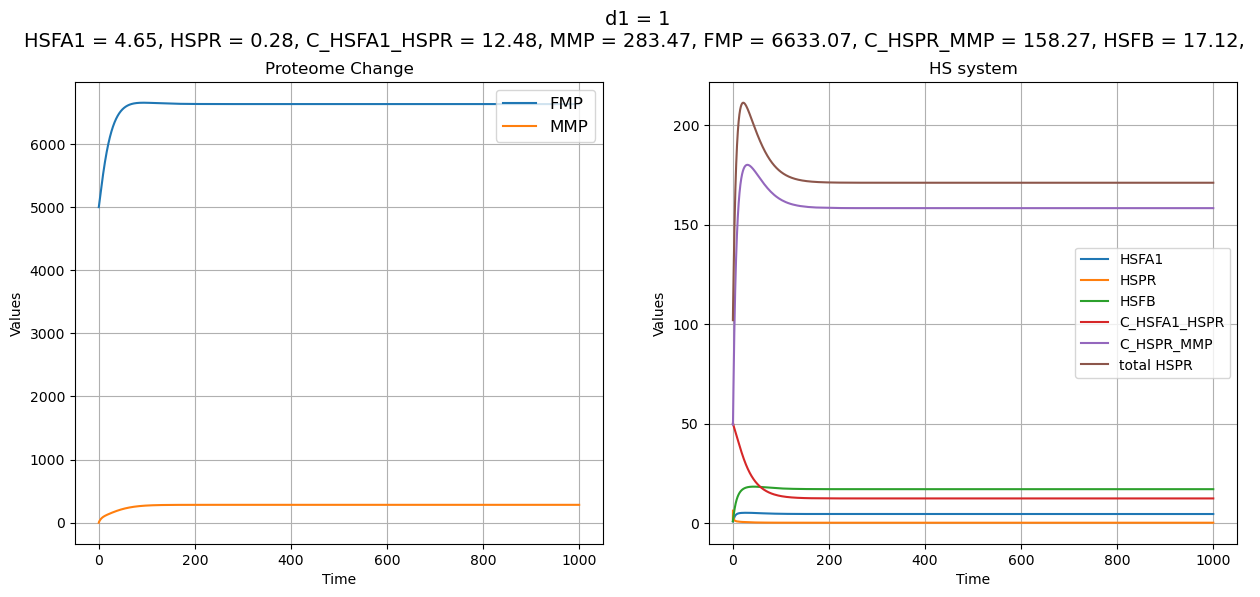

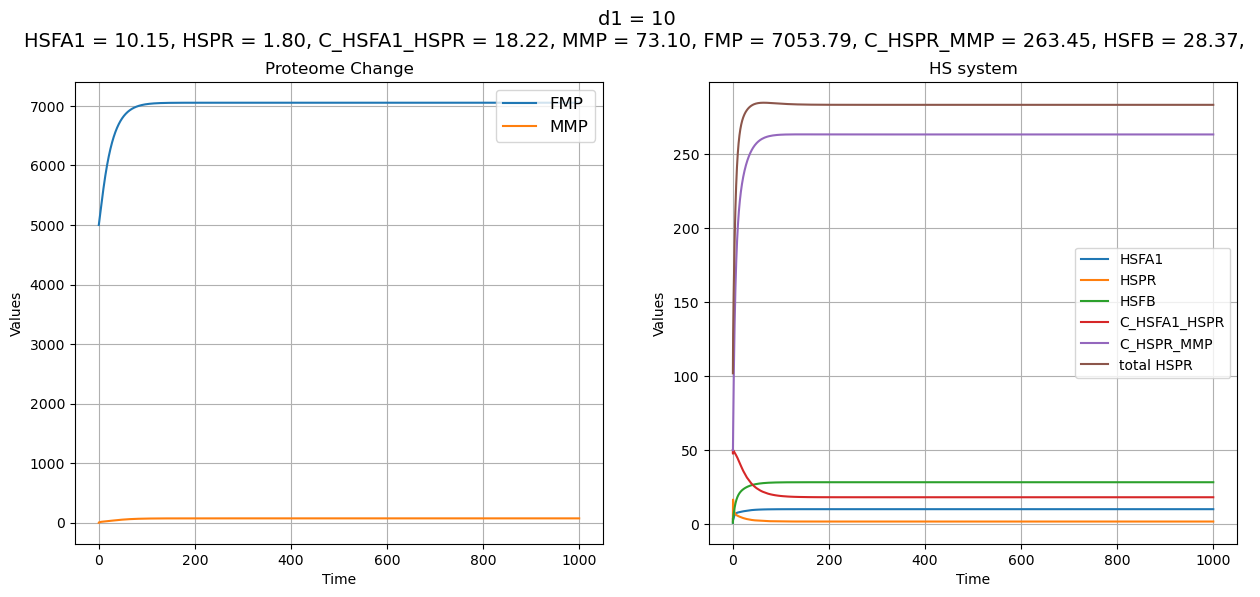

In [45]:
d1_list = [0.001, 0.01, 0.1, 1, 10]
for d1_val in d1_list:
    #unpack param
    a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n = unpack_param_dict(param_dict)
    #change param
    d1 = d1_val
    params = (a1, a2, a5, a6, a7, h1, h2, h5, c1, c3, d1, d3, d4, Decay1, Decay2, Decay4, Decay6, Decay7, Decay8, Decay5, leakage_A1, leakage_B, leakage_HSPR, n)
    # Solve the ODE system
    solution = solve_ivp(ode_system_core, t_span, y0, args=(params,), t_eval=np.linspace(start_time, end_time, num_points))
    plot_sol(solution, f'd1 = {d1_val}')